<a href="https://colab.research.google.com/github/shawal-mbalire/ai_lab_hack/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing data and libraries

In [1]:
!wget https://storage.googleapis.com/air-lab-hackathon/Maize/classification/Classification_maize.zip
!mkdir Maize_Data
!rm -rf sample_data
!cd Maize_Data && unzip ../Classification_maize.zip
!rm Classification_maize.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation/Healthy/Healthy_121.jpg  
  inflating: validation/Healthy/Healthy_1243.jpg  
  inflating: validation/Healthy/Healthy_309.jpg  
  inflating: validation/Healthy/Healthy_1381.jpg  
  inflating: validation/Healthy/Healthy_621.jpg  
  inflating: validation/Healthy/Healthy_2569.jpg  
  inflating: validation/Healthy/Healthy_2256.jpg  
  inflating: validation/Healthy/Healthy_1086.jpg  
  inflating: validation/Healthy/Healthy_2001.jpg  
  inflating: validation/Healthy/Healthy_1628.jpg  
  inflating: validation/Healthy/Healthy_848.jpg  
  inflating: validation/Healthy/Healthy_206.jpg  
  inflating: validation/Healthy/Healthy_1382.jpg  
  inflating: validation/Healthy/Healthy_134.jpg  
  inflating: validation/Healthy/Healthy_1390.jpg  
  inflating: validation/Healthy/Healthy_51.jpg  
  inflating: validation/Healthy/Healthy_2305.jpg  
  inflating: validation/Healthy/Healthy_742.jpg  
  inflating: validation/Healthy/Healthy_

In [2]:
import cv2
import glob
import pandas
import tensorflow
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

```
Numpy 1.25.2
OpenCV4.8.0
Seeborn 0.13.1
Pandas 2.0.3
Scikit Learn1.2.2
Tensorflow 2.15.0
Matplotlib 3.7.1
Keras 2.15.0

glob2==0.7
```

In [13]:
import matplotlib
import sklearn
import keras
# Glob {glob.__version__}
print(f"""
Numpy {np.__version__}
OpenCV{cv2.__version__}
Seeborn {sns.__version__}
Pandas {pandas.__version__}
Scikit Learn{sklearn.__version__}
Tensorflow {tensorflow.__version__}
Matplotlib {matplotlib.__version__}
Keras {keras.__version__}
""")
!pip freeze | grep glob


Numpy 1.25.2
OpenCV4.8.0
Seeborn 0.13.1
Pandas 2.0.3
Scikit Learn1.2.2
Tensorflow 2.15.0
Matplotlib 3.7.1
Keras 2.15.0

glob2==0.7


In [14]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.5
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.6.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.1
cryptography==42.0.7
cuda-python==12.2.1
cudf-cu12 @ https://pypi.nvidia.c

# EDA

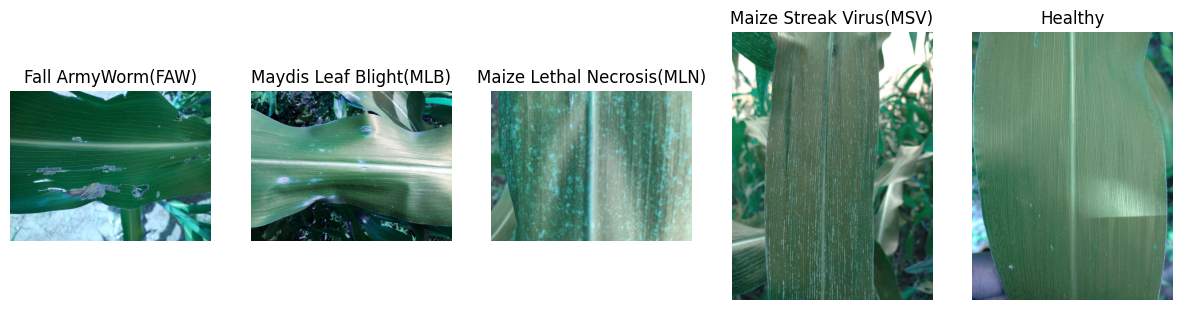

In [18]:
fig = plt.figure(figsize=(15, 5))
rows,columns = 1,5

FAW = cv2.imread('./Maize_Data/train/FAW/FAW_1.jpg')
MLB = cv2.imread('./Maize_Data/train/MLB/MLB_1.jpg')
MLN = cv2.imread('./Maize_Data/train/MLN/MLN_2.jpg')
MSV = cv2.imread('./Maize_Data/train/MSV/MSV_1.jpg')
Healthy = cv2.imread('./Maize_Data/train/Healthy/Healthy_1.jpg')

fig.add_subplot(rows, columns, 1)
plt.imshow(FAW)
plt.axis('off')
plt.title("Fall ArmyWorm(FAW)")

fig.add_subplot(rows, columns, 2)
plt.imshow(MLB)
plt.axis('off')
plt.title("Maydis Leaf Blight(MLB)")

fig.add_subplot(rows, columns, 3)
plt.imshow(MLN)
plt.axis('off')
plt.title("Maize Lethal Necrosis(MLN)")

fig.add_subplot(rows, columns, 4)
plt.imshow(MSV)
plt.axis('off')
plt.title("Maize Streak Virus(MSV)")

fig.add_subplot(rows, columns, 5)
plt.imshow(Healthy)
plt.axis('off')
plt.title("Healthy")
!mkdir images
fig.savefig('images/diseases.png',format='png')
fig.show()

## checking for imbalancedness

In [22]:
df=pandas.DataFrame()
folders = ["FAW","MLB","MSV","MLN","Healthy"]
for folder in folders:
  for i, path in enumerate(glob.glob(f"./Maize_Data/train/{folder}/*.jpg")):
    df = pandas.concat([
        df,
        pandas.DataFrame({
            'image_path' : path,
            'label'      : folder
        },
        index = [i])
    ])

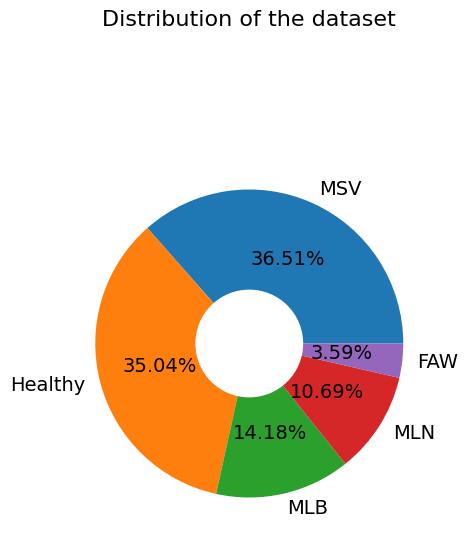

label
MSV        9515
Healthy    9132
MLB        3695
MLN        2786
FAW         935
Name: count, dtype: int64
count       5.000000
mean     5212.600000
std      3884.639662
min       935.000000
25%      2786.000000
50%      3695.000000
75%      9132.000000
max      9515.000000
Name: count, dtype: float64


In [23]:
fig = plt.figure(figsize=(16,5))

plt.pie(
    x=df.label.value_counts(),
    labels=list(df.label.value_counts().index),
    autopct='%1.2f%%',
    textprops={'fontsize':14},
)

plt.title(
    label="Distribution of the dataset",
    fontdict={"fontsize":16},
    pad=90,

)
hole = plt.Circle((0, 0), 0.35, facecolor='white')
plt.gcf().gca().add_artist(hole)

fig.savefig('images/beforePie.png',format='png')
plt.show()
print(df.label.value_counts())
print(df.label.value_counts().describe())

## experimenting with augmentation

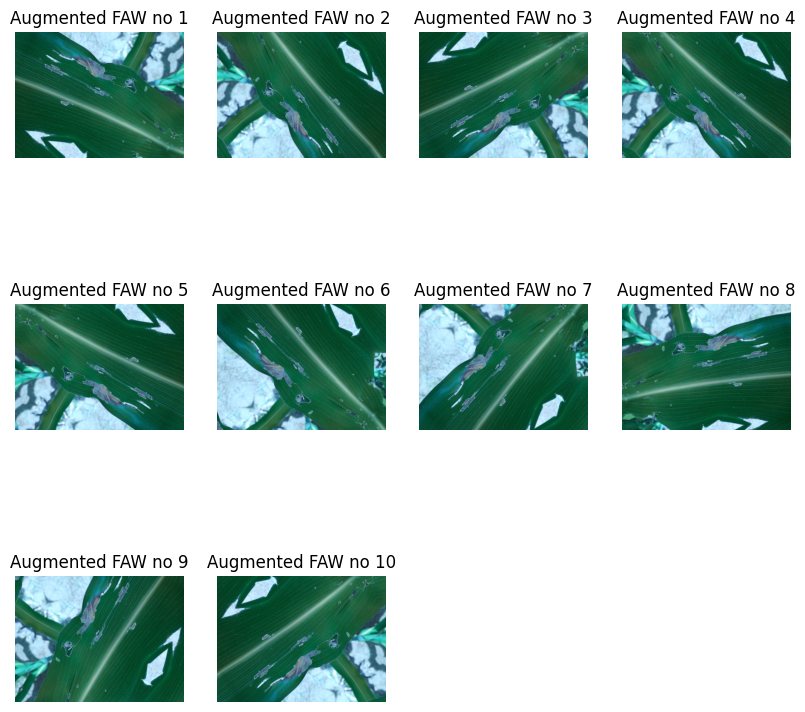

In [30]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.RandomFlip("horizontal_and_vertical"),
  tensorflow.keras.layers.RandomRotation(0.2),
])

image = FAW/255
image = tensorflow.cast(tensorflow.expand_dims(image, 0), tensorflow.float32)

fig = plt.figure(figsize=(10, 10))
for i in range(10):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
  plt.title(f"Augmented FAW no {i+1}")
fig.savefig('images/augmented.png',format='png')
fig.show()

# Creating PyDataset

Pydataset was prefered over image_from_directory due to its easy access to labels using `.labels` python method

In [32]:
train_data_dir          = 'Maize_Data/train'
validation_data_dir = 'Maize_Data/validation'

train_datagen  =  ImageDataGenerator(rescale=1./255)
valid_datagen  =  ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=16,
    classes = ['FAW', 'Healthy', 'MLB', 'MLN', 'MSV']
)

valid = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(256, 256),
    batch_size=16,
    classes = ['FAW', 'Healthy', 'MLB', 'MLN', 'MSV']
)


Found 26063 images belonging to 5 classes.
Found 7445 images belonging to 5 classes.


## Class weighting

as augmentation is resource intensive and doesn't work significantly better than weights, weights were opted for

In [33]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)
print(class_weights)
class_weights = dict(enumerate(class_weights))
print(class_weights)
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.5
    return lr

[5.57497326 0.57080596 1.41071719 1.87099785 0.54782974]
{0: 5.574973262032086, 1: 0.5708059570740254, 2: 1.4107171853856564, 3: 1.8709978463747308, 4: 0.5478297425118235}


# Model building

In [61]:
early_stopping = EarlyStopping(
    monitor='f1_m',
    patience=0,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='f1_m',
    mode='max'
)
base_model = Xception(
    include_top=False,
    input_shape=(256, 256, 3)
)

num_classes = len(train.class_indices)
num_classes

5

In [62]:
model = Sequential()
model.add(base_model)
model.add(tensorflow.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units = num_classes, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 10)                20490     
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 55        
                                                                 
Total params: 20882025 (79.66 MB)
Trainable params: 20827497 (79.45 MB)
Non-trainable params: 54528 (213.00 KB)
________

# Train

In [63]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [64]:
# Compile the model with a lower learning rate for fine-tuning
optimizer = Adam(learning_rate=1e-5)
model.compile(
    optimizer=optimizer,
    loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc',f1_m,precision_m, recall_m]
)

# Train the model with class weights to handle class imbalance
hist = model.fit(
    train,
    epochs=20,
    validation_data=valid,
    callbacks=[LearningRateScheduler(lr_scheduler), model_checkpoint],
    class_weight=class_weights
)

Epoch 1/20
1629/1629 [==============================] - 706s 418ms/step - loss: 0.8514 - acc: 0.6165 - f1_m: 0.4676 - precision_m: 0.7574 - recall_m: 0.3627 - val_loss: 0.3398 - val_acc: 0.9511 - val_f1_m: 0.9224 - val_precision_m: 0.9733 - val_recall_m: 0.8796 - lr: 1.0000e-05
Epoch 2/20
1629/1629 [==============================] - 693s 425ms/step - loss: 0.3795 - acc: 0.8583 - f1_m: 0.8428 - precision_m: 0.9138 - recall_m: 0.7869 - val_loss: 0.1170 - val_acc: 0.9793 - val_f1_m: 0.9773 - val_precision_m: 0.9846 - val_recall_m: 0.9706 - lr: 1.0000e-05
Epoch 3/20
1629/1629 [==============================] - 672s 413ms/step - loss: 0.2803 - acc: 0.8848 - f1_m: 0.8859 - precision_m: 0.9219 - recall_m: 0.8548 - val_loss: 0.0723 - val_acc: 0.9852 - val_f1_m: 0.9854 - val_precision_m: 0.9881 - val_recall_m: 0.9830 - lr: 1.0000e-05
Epoch 4/20
1629/1629 [==============================] - 671s 412ms/step - loss: 0.2297 - acc: 0.8993 - f1_m: 0.9025 - precision_m: 0.9286 - recall_m: 0.8794 - val_

# Visualising training process

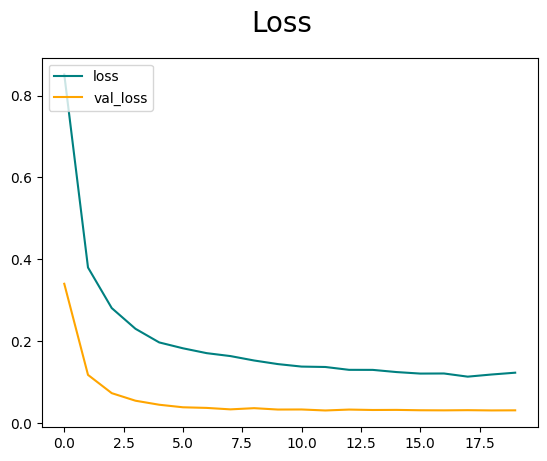

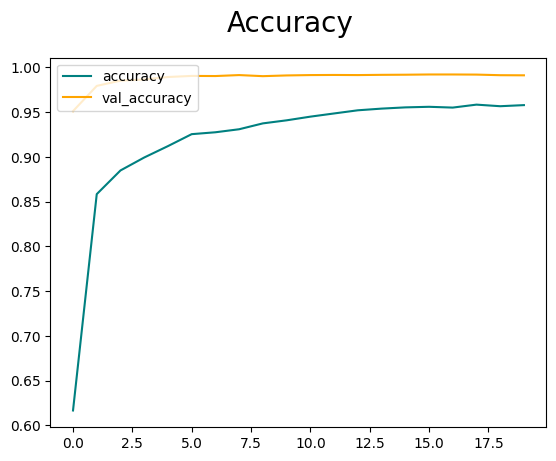

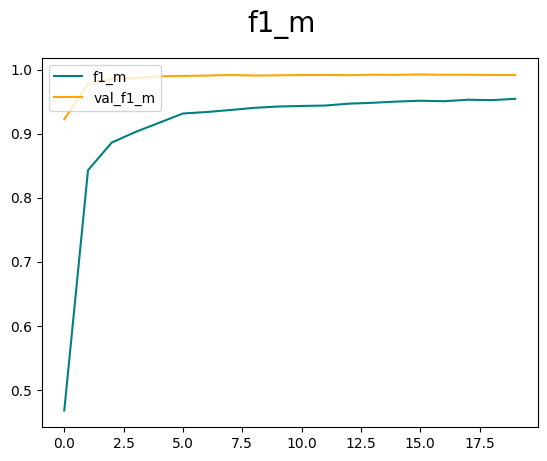

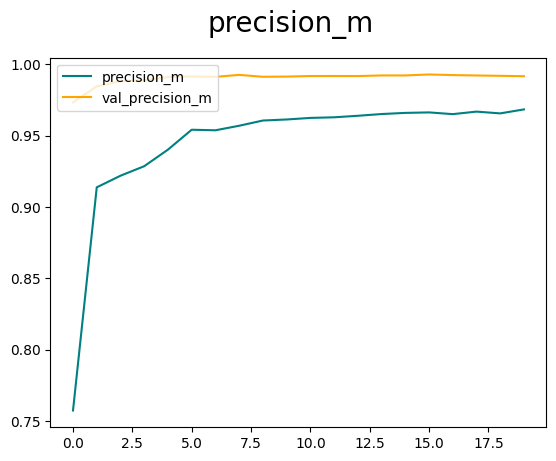

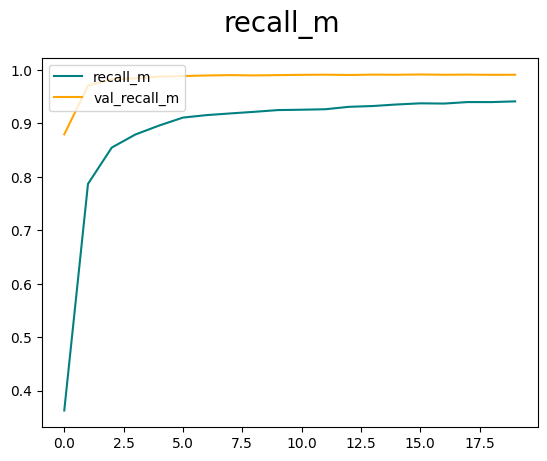

In [67]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
fig.savefig('loss.png',format='png')
plt.show()

fig = plt.figure()
plt.plot(hist.history['acc'], color='teal', label='accuracy')
plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
fig.savefig('accuracy.png',format='png')
plt.show()

fig = plt.figure()
plt.plot(hist.history['f1_m'], color='teal', label='f1_m')
plt.plot(hist.history['val_f1_m'], color='orange', label='val_f1_m')
fig.suptitle('f1_m', fontsize=20)
plt.legend(loc="upper left")
fig.savefig('f1_m.png',format='png')
plt.show()

fig = plt.figure()
plt.plot(hist.history['precision_m'], color='teal', label='precision_m')
plt.plot(hist.history['val_precision_m'], color='orange', label='val_precision_m')
fig.suptitle('precision_m', fontsize=20)
plt.legend(loc="upper left")
fig.savefig('precision.png',format='png')
plt.show()

fig = plt.figure()
plt.plot(hist.history['recall_m'], color='teal', label='recall_m')
plt.plot(hist.history['val_recall_m'], color='orange', label='val_recall_m')
fig.suptitle('recall_m', fontsize=20)
plt.legend(loc="upper left")
fig.savefig('recall.png',format='png')
plt.show()

In [68]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 10)                20490     
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 55        
                                                                 
Total params: 20882025 (79.66 MB)
Trainable params: 20827497 (79.45 MB)
Non-trainable params: 54528 (213.00 KB)
________

## testing model

In [69]:
print("faw, healthy, mlb, mln, msv")

faw_path = "Maize_Data/train/FAW/FAW_1.jpg"
faw_image = cv2.imread(faw_path)
resized_faw_img = tensorflow.image.resize(faw_image,[256,256])
faw, healthy, mlb, mln, msv = model.predict(np.expand_dims(resized_faw_img/255,0))[0]
print(faw, healthy, mlb, mln, msv)

path = "Maize_Data/train/Healthy/Healthy_1.jpg"
image = cv2.imread(path)
path_1 = tensorflow.image.resize(image,[256,256])
faw, healthy, mlb, mln, msv = model.predict(np.expand_dims(path_1/255,0))[0]
print(faw, healthy, mlb, mln, msv)

path = "Maize_Data/train/MLB/MLB_1.jpg"
image = cv2.imread(path)
path_1 = tensorflow.image.resize(image,[256,256])
faw, healthy, mlb, mln, msv = model.predict(np.expand_dims(path_1/255,0))[0]
print(faw, healthy, mlb, mln, msv)

path = "Maize_Data/train/MLN/MLN_1.jpg"
image = cv2.imread(path)
path_1 = tensorflow.image.resize(image,[256,256])
faw, healthy, mlb, mln, msv = model.predict(np.expand_dims(path_1/255,0))[0]
print(faw, healthy, mlb, mln, msv)

path = "Maize_Data/train/MSV/MSV_1.jpg"
image = cv2.imread(path)
path_1 = tensorflow.image.resize(image,[256,256])
faw, healthy, mlb, mln, msv = model.predict(np.expand_dims(path_1/255,0))[0]
print(faw, healthy, mlb, mln, msv)

faw, healthy, mlb, mln, msv
1/1 [==============================] - 1s 858ms/step
0.9999453 1.3343387e-07 5.457027e-05 3.6047712e-10 4.5543595e-12
1/1 [==============================] - 0s 23ms/step
2.2248667e-09 0.9999999 5.625382e-08 5.4264532e-08 1.1098684e-09
1/1 [==============================] - 0s 22ms/step
0.008051588 0.9360846 0.03494315 0.0066376813 0.014282982
1/1 [==============================] - 0s 22ms/step
0.0001916836 0.91398793 0.0012445115 0.07727396 0.007301911
1/1 [==============================] - 0s 36ms/step
0.000599486 0.003755235 0.00040705357 0.0039411597 0.9912971


# Creating Submission

In [ ]:
df = pandas.DataFrame(columns=['filename','faw', 'healthy', 'mlb', 'mln', 'msv'])
path = 'Maize_Data/test'
files = glob.glob(path + "/*.jpg")

for path in files:
    image = cv2.imread(path)
    path_1 = tensorflow.image.resize(image,[256,256])
    faw, healthy, mlb, mln, msv = model.predict(np.expand_dims(path_1/255,0))[0]

    folders_and_file = path.split('/')

    file_name = folders_and_file[-1]
    df = pandas.concat([pandas.DataFrame([[file_name,faw, healthy, mlb, mln, msv]],columns=df.columns),df])

df

1/1 [==============================] - 0s 33ms/step


In [1]:
df.to_csv('18446744073709551616.csv',index=False)

NameError: name 'df' is not defined